# Preparacion de los datos

In [1]:
from lib.utilities import unpickle, tryDataset, mkfolders, compute_mixture, load_mixture, os

(50000, 32, 32, 3)


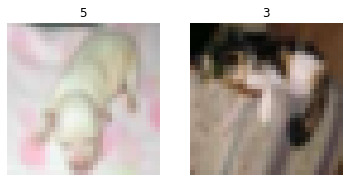

(10000, 32, 32, 3)


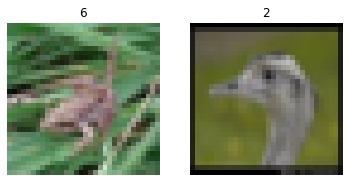

In [2]:
X_train = unpickle("Input\cifar-10-train")
X_test = unpickle("Input\cifar-10-test")
tryDataset(X_train)
tryDataset(X_test)

# Entrenamiento

## Persistencia

In [3]:
_raiz = "Resultados/CIFAR10pruebasAAE"
_nombre = "CIFAR10"

Creamos las carpetas para almacenar el output

In [4]:
mkfolders(_raiz, True)

Carpeta Resultados/CIFAR10pruebasAAE ya existe


## Entrenamiento en grid

Tamaño de la capa latente:

In [5]:
dim_latente_cand = [100, 512, 1024]

Tamaño de las imagenes:

In [6]:
img_shape = X_train["data"][0].shape

Parametros:

In [7]:
from lib.discriminadores import *
from lib.genEJ import *
from keras import losses

In [8]:
discriminators = [(build_discriminator ,"default_disc", {}, {"truth":true_sampler, "truth_kwargs":{}, "falsehood":fake_sampler}),
                    (build_class_discriminator ,"class_disc",{"clases":10}, {"truth":true_sampler_clases, "truth_kwargs":{"nclases":10}, "falsehood":fake_class_sampler})]


ae_losses = [(losses.mean_squared_error, "ae_MSE_loss")]
disc_losses =[(losses.binary_crossentropy, "disc_binXentropy_loss")]

In [9]:
epochs = 12

In [10]:
from lib.compilado import assemble_AAE_twoPhased
from lib.entrenamiento import fit_AAE_twoPhased
from lib.densa import build_dense_decoder, build_dense_encoder
from lib.muestreo import show_prevResults, plot_history, sample_imgs, exploraLatente

In [11]:
from lib.compilado import assemble_AAE_twoPhased
from lib.entrenamiento import fit_AAE_twoPhased
from lib.densa import build_dense_decoder, build_dense_encoder
from lib.muestreo import show_prevResults, plot_history, sample_imgs, exploraLatente

In [12]:
def tryModel(
    model_name="MODEL", 
    assemble_AAE=assemble_AAE_twoPhased,
    loss_weights=[1, 1], 
    fit_AAE = fit_AAE_twoPhased,
    enc= (build_dense_encoder, "dense_enc", {}), 
    dec = (build_dense_decoder,"dense_dec", {}),
    ae_loss = (losses.mean_squared_error, "ae_MSE_loss"),
    disc = (build_discriminator_P ,"pyramid_disc", {}, {"truth":true_sampler, "truth_kwargs":{}, "falsehood":fake_sampler}),
    disc_loss = (losses.binary_crossentropy, "disc_binXentropy_loss"),
    dim_latente = 64,
    mixture_data={"override":False, "nombre":"cluster"},
    save=False
    ):
    # Carpeta donde almacenar los resultados
    ruta = _raiz+"\\"+model_name+"\\"+ae_loss[1]+"\\"+disc[1]+"\\"+disc_loss[1]+"\\"+str(dim_latente)
    # Si existen los modelos solo mostrar resultados guardados sin entrenar
    if os.path.isfile(ruta+"/Modelos\\decoder.h5") or os.path.isfile(ruta+"/Modelos\\autoencoder.h5"):
        print(ruta+" ya ha sido entrenada")
        show_prevResults(ruta, epochs=epochs)
        return
    # Crear carpeta
    mkfolders(ruta, True)
    # Intentar cargar datos de mixtura si se trata de un dsicriminador con informacion de clases
    fit_settings = disc[3]
    if "clases" in disc[2].keys():
        mixture = load_mixture(ruta="Data/", dataset_name=_nombre, expansion=10, **mixture_data)
        fit_settings["truth_kwargs"].update({"mixture":mixture})
    # Creacion de los modelos
    aae = assemble_AAE(dim_latente, img_shape, enc_model = enc[0], enc_kwargs=enc[2], dec_model = dec[0], dec_kwargs=dec[2], disc_model = disc[0], disc_kwargs=disc[2], ae_loss=ae_loss[0], disc_loss=disc_loss[0], loss_weights=loss_weights)
    # Entrenamiento
    history = fit_AAE(aae=aae, dim_latente=dim_latente, dataset=X_train, epochs = epochs, ruta = ruta, **fit_settings)
    # Obtenemos informacion del numero de clases para mostrar resultados, si no hay se intenta generar una mixtura para mas tarde
    clases=0
    if "clases" in disc[2].keys():
        clases=disc[2]["clases"]
    else:
        compute_mixture(X_train, aae[0], ruta="Data/", dataset_name=_nombre, **mixture_data)
    #Resultados
    print("Historia del entrenamiento:")
    plot_history(history, ruta=ruta, title=ruta)
    print("Imagenes regeneradas desde el set de entrenamiento (arriba originales):")
    sample_imgs(X_train, aae[3], epoch=epochs, nclases=clases, show=True, ruta=ruta, title=ruta+" regeneration", nombre="TRAINSET")
    print("Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):")
    sample_imgs(X_test, aae[3], epoch=epochs, nclases=clases, show=True, ruta=ruta, title=ruta+" regeneration", nombre="TESTSET")
    print("Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Train):")
    exploraLatente(aae[0], aae[1], "Input\cifar-10-groupedtrain", ruta=ruta, nombre="GenFromLatentTRAINSET")
    print("Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Test):")
    exploraLatente(aae[0], aae[1], "Input\cifar-10-groupedtest", ruta=ruta, nombre="GenFromLatentTESTSET")
    # Guardado de modelos
    if save:
        mkfolders(ruta+"/Modelos")
        aae[1].save(ruta+"/Modelos\\decoder.h5")
        aae[3].save(ruta+"/Modelos\\autoencoder.h5")


### Entrenamiento de AAE Denso - Baseline

In [13]:
dim_latente = 512
model_name = "DENSE"
loss_weigths = [0.999, 0.001]

Default

Carpeta Resultados/CIFAR10pruebasAAE\DENSE\ae_MSE_loss\pyramid_disc\disc_binXentropy_loss\512 ya existe
Layers for input 512 and output 1:
Layer 1: 64 neurons
Layer 2: 8 neurons
Entrenando: Resultados/CIFAR10pruebasAAE\DENSE\ae_MSE_loss\pyramid_disc\disc_binXentropy_loss\512


C:\Users\bitde\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['labels'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


E0 <██████████> 100% DISC: [loss: 20.938530, acc: 28.00%] AAE: [mse: 0.058222, b_ce: 0.057923] 34.30s		
E1 <██████████> 100% DISC: [loss: 0.440829, acc: 69.50%] AAE: [mse: 1.120420, b_ce: 0.059009] 32.88s		
E2 <██████████> 100% DISC: [loss: 16.208431, acc: 0.00%] AAE: [mse: 18.147190, b_ce: 0.069627] 33.02s		
E3 <██████████> 100% DISC: [loss: 2.549778, acc: 0.00%] AAE: [mse: 5.788847, b_ce: 0.060956] 32.92s		
E4 <██████████> 100% DISC: [loss: 0.584612, acc: 62.50%] AAE: [mse: 2.083263, b_ce: 0.055079] 33.11s		
E5 <██████████> 100% DISC: [loss: 1.714881, acc: 31.00%] AAE: [mse: 0.414171, b_ce: 0.051731] 33.02s		
E6 <██████████> 100% DISC: [loss: 1.527049, acc: 12.00%] AAE: [mse: 0.384988, b_ce: 0.050398] 32.86s		
E7 <██████████> 100% DISC: [loss: 1.149884, acc: 9.00%] AAE: [mse: 0.925822, b_ce: 0.047323] 33.16s		
E8 <██████████> 100% DISC: [loss: 2.729587, acc: 0.00%] AAE: [mse: 0.618388, b_ce: 0.050719] 32.72s		
E9 <██████████> 100% DISC: [loss: 0.560731, acc: 60.50%] AAE: [mse: 1.9821

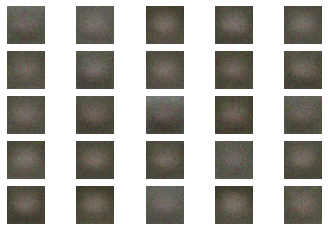

Guardando datos de la mixtura para CIFAR10-cluster
Historia del entrenamiento:


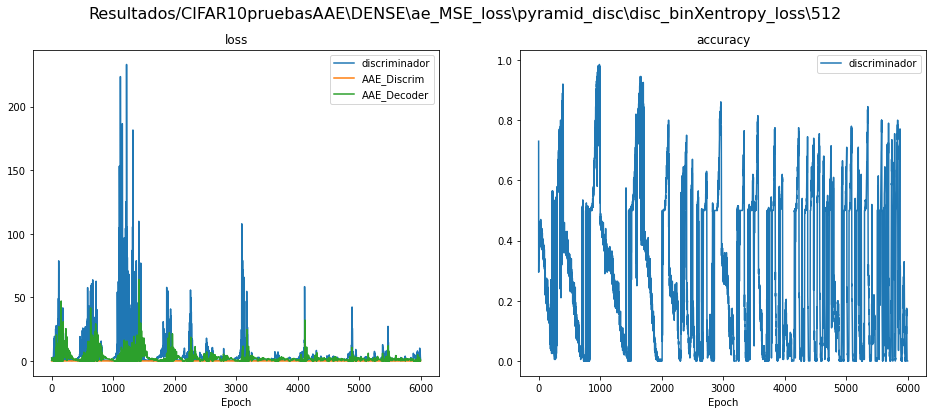

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


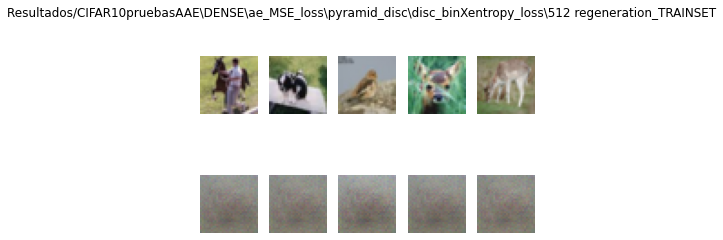

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


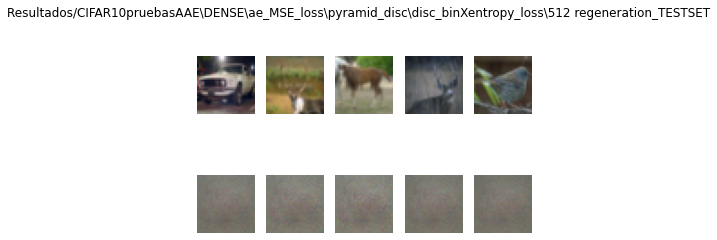

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Train):


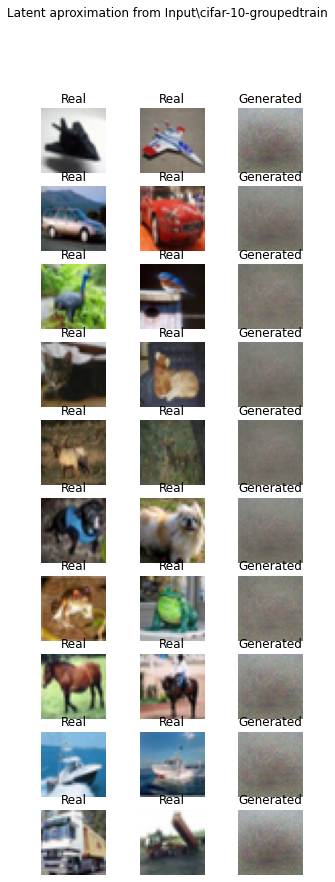

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Test):


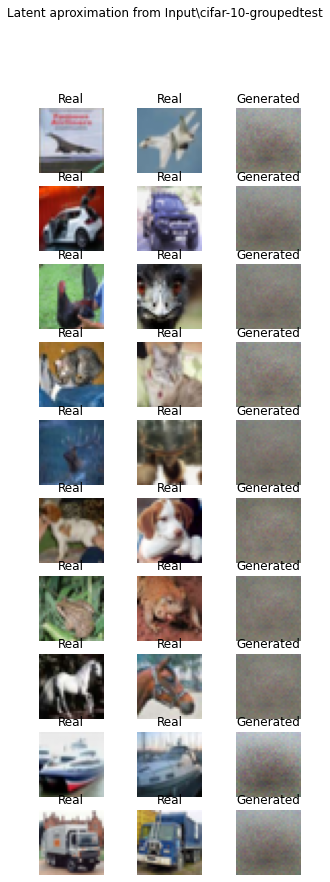

In [13]:
tryModel(dim_latente=dim_latente, model_name=model_name)

Default + lossweigths 99%

Carpeta Resultados/CIFAR10pruebasAAE\DENSE\ae_MSE_loss\pyramid_disc\disc_binXentropy_loss\512 ya existe
Layers for input 512 and output 1:
Layer 1: 64 neurons
Layer 2: 8 neurons
Entrenando: Resultados/CIFAR10pruebasAAE\DENSE\ae_MSE_loss\pyramid_disc\disc_binXentropy_loss\512


C:\Users\bitde\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['labels'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


E0 <██████████> 100% DISC: [loss: 0.772060, acc: 56.00%] AAE: [mse: 0.039685, b_ce: 0.037338] 33.61s		
E1 <██████████> 100% DISC: [loss: 0.937356, acc: 46.00%] AAE: [mse: 0.025844, b_ce: 0.023889] 32.70s		
E2 <██████████> 100% DISC: [loss: 0.477017, acc: 81.50%] AAE: [mse: 0.024364, b_ce: 0.022994] 32.96s		
E3 <██████████> 100% DISC: [loss: 0.507881, acc: 76.00%] AAE: [mse: 0.026890, b_ce: 0.025022] 32.80s		
E4 <██████████> 100% DISC: [loss: 0.453871, acc: 84.00%] AAE: [mse: 0.017253, b_ce: 0.015600] 32.83s		
E5 <██████████> 100% DISC: [loss: 0.529621, acc: 75.50%] AAE: [mse: 0.019548, b_ce: 0.018236] 32.83s		
E6 <██████████> 100% DISC: [loss: 0.539972, acc: 77.00%] AAE: [mse: 0.017219, b_ce: 0.015871] 32.96s		
E7 <██████████> 100% DISC: [loss: 1.119173, acc: 46.50%] AAE: [mse: 0.017904, b_ce: 0.016052] 32.90s		
E8 <██████████> 100% DISC: [loss: 2.766044, acc: 16.00%] AAE: [mse: 0.043811, b_ce: 0.042305] 32.84s		
E9 <██████████> 100% DISC: [loss: 0.930862, acc: 54.50%] AAE: [mse: 0.019

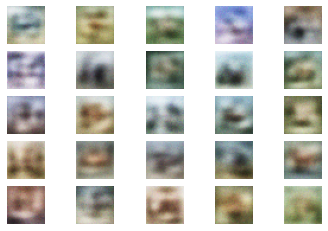

Historia del entrenamiento:


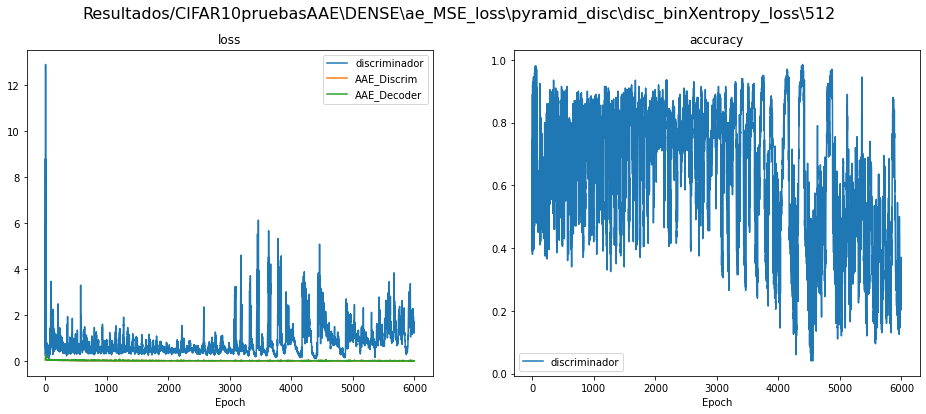

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


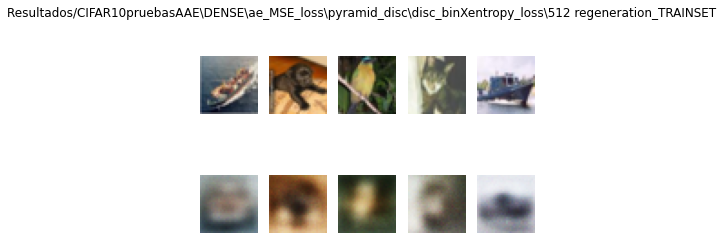

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


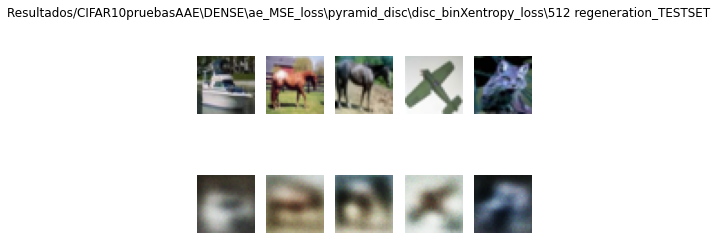

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Train):


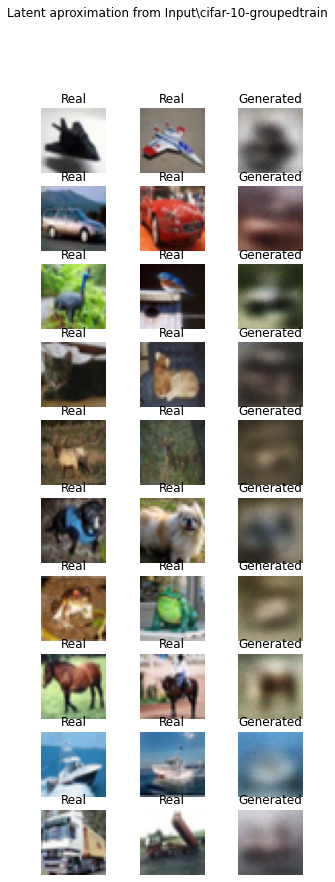

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Test):


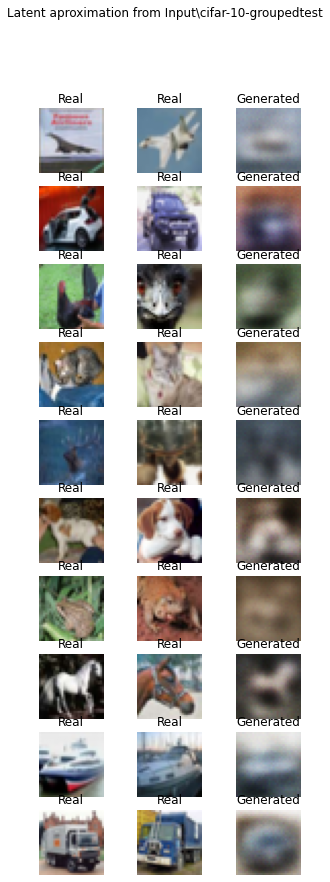

In [14]:
tryModel(loss_weights=loss_weigths, dim_latente=dim_latente, model_name=model_name)

Mismo loss weigth para decoder y discriminador

Carpeta Resultados/CIFAR10pruebasAAE\DENSE\ae_MSE_loss\pyramid_disc\disc_binXentropy_loss\512 ya existe
Layers for input 512 and output 1:
Layer 1: 108 neurons
Layer 2: 23 neurons
Layer 3: 5 neurons
Entrenando: Resultados/CIFAR10pruebasAAE\DENSE\ae_MSE_loss\pyramid_disc\disc_binXentropy_loss\512


C:\Users\bitde\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['labels'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


E0 <██████████> 100% DISC: [loss: 0.479767, acc: 96.50%] AAE: [mse: 0.915225, b_ce: 0.056918] 54.59s		
E1 <██████████> 100% DISC: [loss: 0.461864, acc: 79.00%] AAE: [mse: 7.298398, b_ce: 0.298511] 51.86s		
E2 <██████████> 100% DISC: [loss: 34.051892, acc: 31.50%] AAE: [mse: 58.938766, b_ce: 0.299579] 51.92s		
E3 <██████████> 100% DISC: [loss: 0.411716, acc: 85.00%] AAE: [mse: 1.621433, b_ce: 0.057567] 51.97s		
E4 <██████████> 100% DISC: [loss: 6.886178, acc: 50.00%] AAE: [mse: 46.593266, b_ce: 0.297810] 52.05s			
E5 <██████████> 100% DISC: [loss: 0.298451, acc: 87.00%] AAE: [mse: 9.520969, b_ce: 0.284877] 52.24s				
E6 <██████████> 100% DISC: [loss: 2.400973, acc: 45.00%] AAE: [mse: 30.125025, b_ce: 0.300215] 52.09s		
E7 <██████████> 100% DISC: [loss: 40.230677, acc: 6.00%] AAE: [mse: 260.372650, b_ce: 0.311163] 52.15s		
E8 <██████████> 100% DISC: [loss: 0.081082, acc: 97.50%] AAE: [mse: 14.766169, b_ce: 0.295572] 52.18s			
E9 <██████████> 100% DISC: [loss: 0.044152, acc: 99.00%] AAE: 

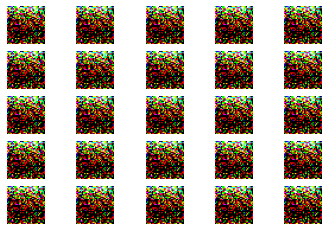

Guardando datos de la mixtura para CIFAR10-cluster
Historia del entrenamiento:


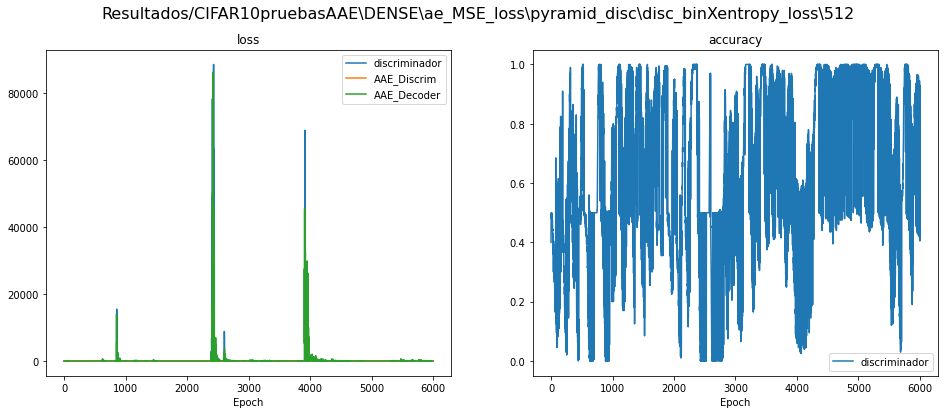

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


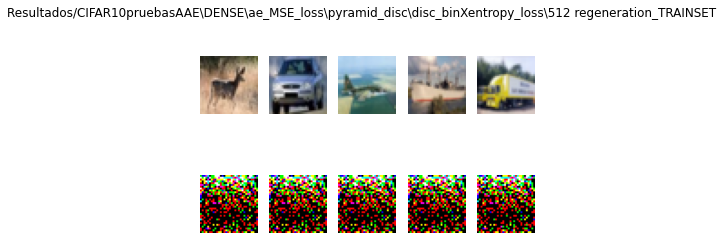

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


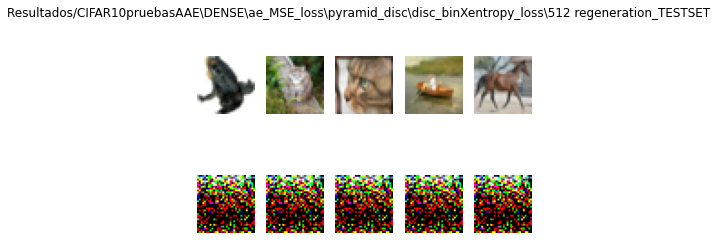

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Train):


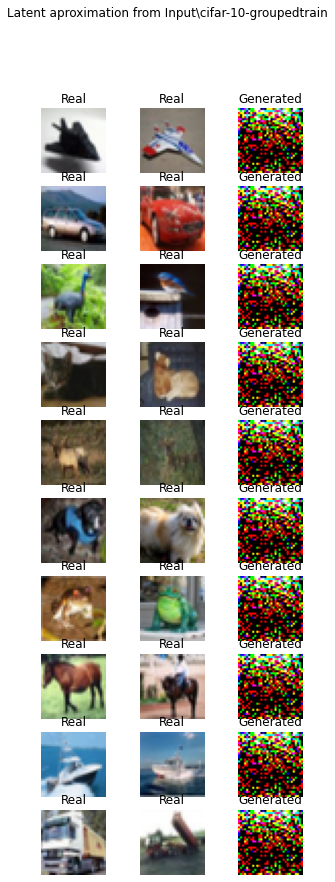

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Test):


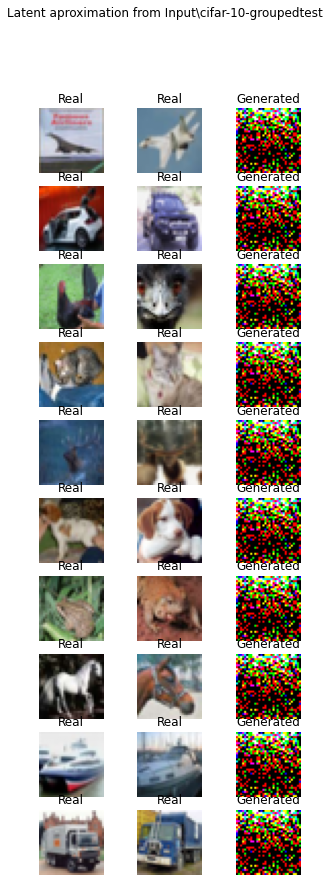

In [14]:
enc = (build_dense_encoder, "dense_enc",{"depth":4, "width":4000})
dec = (build_dense_decoder, "dense_dec",{"depth":4, "width":4000})
disc = (build_discriminator_P ,"pyramid_disc", {"depth":3}, {"truth":true_sampler, "truth_kwargs":{}, "falsehood":fake_sampler})
tryModel(enc=enc, dec=dec, disc=disc, dim_latente=dim_latente, model_name=model_name)


99.9% de lossweigth para el decoder

Carpeta Resultados/CIFAR10pruebasAAE\DENSE\ae_MSE_loss\pyramid_disc\disc_binXentropy_loss\512 ya existe
Layers for input 512 and output 1:
Layer 1: 108 neurons
Layer 2: 23 neurons
Layer 3: 5 neurons
Entrenando: Resultados/CIFAR10pruebasAAE\DENSE\ae_MSE_loss\pyramid_disc\disc_binXentropy_loss\512


C:\Users\bitde\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['labels'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


E0 <██████████> 100% DISC: [loss: 0.845888, acc: 25.50%] AAE: [mse: 0.288892, b_ce: 0.287911] 52.20s		
E1 <██████████> 100% DISC: [loss: 1.179050, acc: 24.00%] AAE: [mse: 0.041216, b_ce: 0.038971] 51.16s		
E2 <██████████> 100% DISC: [loss: 0.299175, acc: 92.50%] AAE: [mse: 0.041630, b_ce: 0.039051] 51.31s		
E3 <██████████> 100% DISC: [loss: 0.489821, acc: 80.00%] AAE: [mse: 0.044014, b_ce: 0.041965] 51.41s		
E4 <██████████> 100% DISC: [loss: 1.736791, acc: 13.50%] AAE: [mse: 0.363903, b_ce: 0.316437] 51.65s		
E5 <██████████> 100% DISC: [loss: 0.364897, acc: 85.50%] AAE: [mse: 0.035069, b_ce: 0.032699] 51.44s		
E6 <██████████> 100% DISC: [loss: 2.388402, acc: 50.00%] AAE: [mse: 1.183594, b_ce: 0.306343] 51.54s		
E7 <██████████> 100% DISC: [loss: 0.429100, acc: 71.50%] AAE: [mse: 0.309483, b_ce: 0.285214] 51.67s		
E8 <██████████> 100% DISC: [loss: 0.271314, acc: 88.50%] AAE: [mse: 0.291200, b_ce: 0.281441] 51.38s		
E9 <██████████> 100% DISC: [loss: 0.171831, acc: 94.50%] AAE: [mse: 0.281

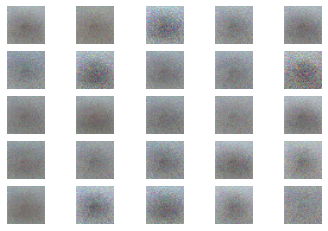

Historia del entrenamiento:


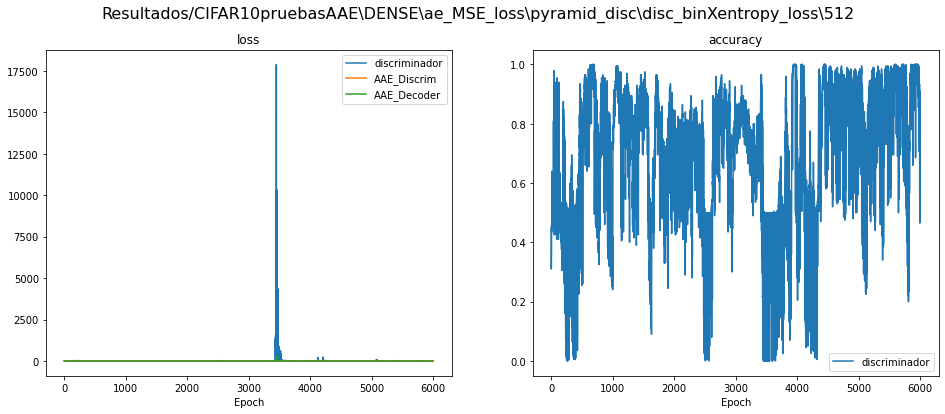

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


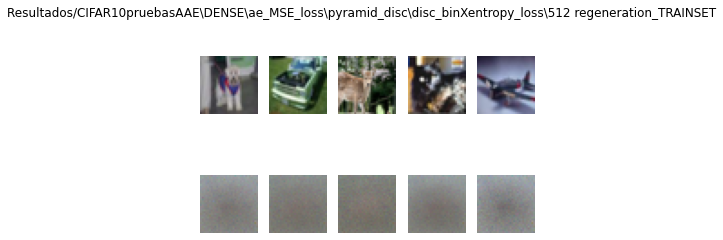

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


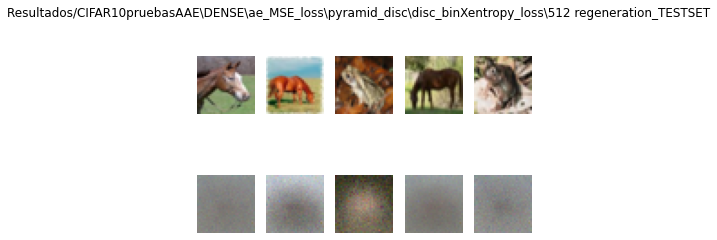

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Train):


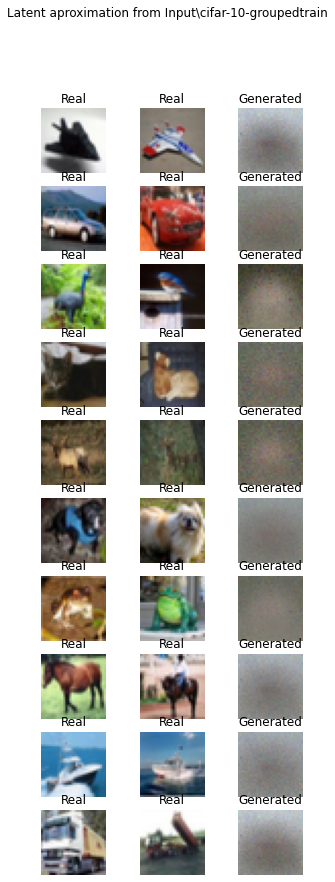

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Test):


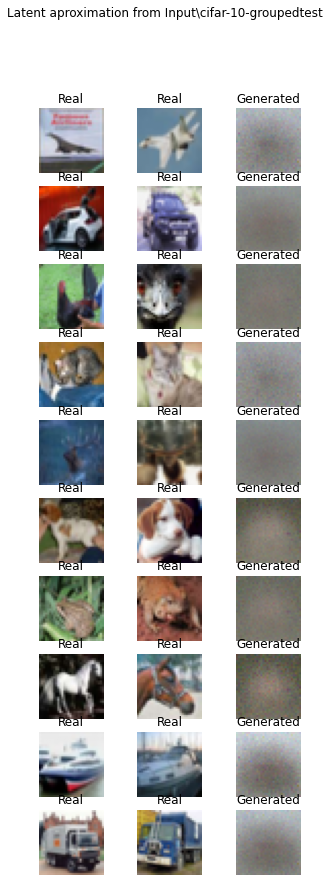

In [14]:
enc = (build_dense_encoder, "dense_enc",{"depth":4, "width":4000})
dec = (build_dense_decoder, "dense_dec",{"depth":4, "width":4000})
disc = (build_discriminator_P ,"pyramid_disc", {"depth":3}, {"truth":true_sampler, "truth_kwargs":{}, "falsehood":fake_sampler})
model_name = "DENSE"
tryModel(loss_weights=loss_weigths, enc=enc, dec=dec, disc=disc, dim_latente=dim_latente, model_name=model_name, mixture_data={"override":False, "nombre":str(dim_latente)+"cluster"})
